### RNA-SeQC 2: main figures

This notebook contains the code for generating Fig. 1 from the manuscript. A notebook for the supplemental figures is provided [separately](Supplementary_Figures.ipynb).

Metrics tables from various datasets used in the paper are provided in the [data](data) directory of this repository.

Sample annotations from GTEx and read counts from RNA-SeQC 2 can be downloaded by uncommenting and running the cell below.

In [1]:
# !wget -P data/ https://personal.broadinstitute.org/francois/rnaseqc2_paper/GTEx_v8_18655_samples_RNASeQCv2.3.6.gene_reads.gct.gz
# !wget -P data/ https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
matplotlib.font_manager._rebuild()
plt.rcParams.update({'font.family': 'Helvetica', 'svg.fonttype':'none', 'pdf.fonttype':42})
import seaborn as sns

import qtl.plot
import qtl.pca
import rnaseqc.plot

if not os.path.exists:
    os.mkdir('pdf')

#### Load inputs

In [3]:
gtex_counts_df = pd.read_parquet('data/GTEx_v8_18655_samples_RNASeQCv2.3.6.gene_reads.parquet')

gtex_metrics_df = pd.read_csv('data/GTEx_v8_18655_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                         sep='\t', index_col=0)
ffpe_metrics_df = pd.read_csv('data/VanAllen2015_32_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                              sep='\t', index_col=0)
entex_metrics_df = pd.read_csv('data/ENTEx_97_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                               sep='\t', index_col=0)
cptac2_metrics_df = pd.read_csv('data/CPTAC2_CRC_105_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                                sep='\t', index_col=0)
cptac3_metrics_df = pd.read_csv('data/CPTAC3_LUAD_214_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                                sep='\t', index_col=0)

sample_df = pd.read_csv('data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',
                        sep='\t', index_col=0, low_memory=False)
sample_df = sample_df[(sample_df['SMGEBTCHT']=='TruSeq.v1') &
                      sample_df.index.str.startswith('GTEX')]
sample_df['tissue_id'] = sample_df['SMTSD'].apply(lambda x: x.replace('(','').replace(')','').replace(' - ', ' ').replace(' ', '_'))


#### Panel A: metrics across different protocols

In [4]:
sample_ids = (sample_df[sample_df['tissue_id'] == 'Pancreas'].index.tolist()[:100] + 
              sample_df[sample_df['tissue_id'] == 'Cells_Cultured_fibroblasts'].index.tolist()[:100])

metrics_all_df = pd.concat([
    ffpe_metrics_df,
    cptac2_metrics_df,
    cptac3_metrics_df,
    gtex_metrics_df.loc[sample_ids],
    entex_metrics_df,
])
cohort_s = pd.Series('GTEx, polyA+', index=metrics_all_df.index)
cohort_s[entex_metrics_df.index] = 'GTEx, total RNA'
cohort_s[cptac2_metrics_df.index] = 'CPTAC, polyA+'
cohort_s[cptac3_metrics_df.index] = 'CPTAC, total RNA'
cohort_s[ffpe_metrics_df.index] = 'FFPE, capture'

cohort_colors = {
    'GTEx, polyA+':     hsv_to_rgb([0.55, 0.8, 0.6]),
    'GTEx, total RNA':  hsv_to_rgb([0.55, 0.8, 0.8]),
    'CPTAC, polyA+':    hsv_to_rgb([0.05, 0.8, 0.6]),
    'CPTAC, total RNA': hsv_to_rgb([0.05, 0.8, 0.8]),
    'FFPE, capture':    hsv_to_rgb([0.25, 0.8, 0.6]),
}


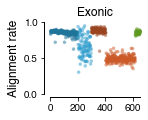

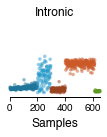

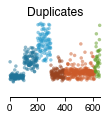

In [5]:
ylim_dict = {
    'Duplicate Rate of Mapped': [0, 1],
    'Exonic Rate': [0, 1],
    'Intronic Rate': [0, 1],
}

cohorts = list(cohort_colors)
for k,metric in enumerate(['Exonic Rate', 'Intronic Rate', 'Duplicate Rate of Mapped']):
    v = metrics_all_df[metric].copy()
    v[v == 0] = np.NaN
    ax = rnaseqc.plot.metrics(v, cohort_s=cohort_s, cohort_colors=cohort_colors,
                              cohort_order=cohorts, ylim=ylim_dict[metric],
                              ms=12, alpha=0.5, plot_density=False,
                              ah=1, dt=0.25, db=0.5, dl=0.75, rasterized=False,
                              aw=1.25, ds=0.25, daw=0.5, dr=0.1)

    ax.set_xticks(np.arange(0, 800, 200))
    ax.spines['left'].set_position(('outward', 6))
    ax.spines['bottom'].set_position(('outward', 3))
    ax.set_xlabel('Samples', fontsize=12)
    title = metric.replace('Ambiguous Alignment', 'Amb. Align.').replace(
        'Duplicate Rate of Mapped', 'Duplicate Rate')
    ax.set_title(title.replace(' Rate', '').replace('Duplicate', 'Duplicates'), fontsize=12)
    if k == 0:
        ax.set_ylabel('Alignment rate', fontsize=12)
    if k != 1:
        ax.set_xlabel(None)
    if k > 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_ylabel(None)
    plt.savefig(f"pdf/Fig1A.protocols.{metric.replace(' ','_')}.pdf", dpi=300)


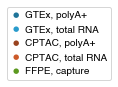

In [6]:
ax = qtl.plot.setup_figure(0, 1, xspace=[0.05, 1.5], yspace=[0.5, 0.125])
qtl.plot.format_plot(ax, hide=['top', 'bottom', 'left', 'right'])
ax.set_xticks([])
ax.set_yticks([])
lg = [ax.scatter([],[], s=30, c=[cohort_colors[k]], lw=0.5, edgecolor='none', label=k) for k in cohorts]
leg = ax.legend(lg, cohorts, fontsize=10, labelspacing=None, handletextpad=0.4,
    handlelength=1, loc='upper left', borderpad=None, borderaxespad=0, bbox_to_anchor=(1.1,1))
plt.savefig('pdf/protocols.legend.pdf')

#### Panel B: RIN vs. 3' bias & ischemic time

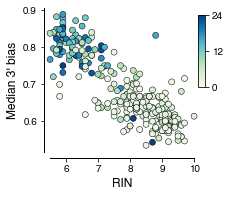

In [7]:
tissue_id = 'Adrenal_Gland'
sample_ids = sample_df[sample_df['tissue_id'] == tissue_id].index
rin = sample_df.loc[sample_ids, 'SMRIN']
bias = gtex_metrics_df.loc[sample_ids, "Median 3' bias"]
isch = sample_df.loc[sample_ids, 'SMTSISCH'] / 60

ax, cax = qtl.plot.setup_figure(2, 2, xspace=[0.75, 0.5],
                                colorbar=True, ds=0.05, cw=0.1, ct=0.1)
h = ax.scatter(rin, bias, c=isch, cmap=plt.cm.GnBu,
               clip_on=False, s=36, edgecolor='k',lw=0.5,
               vmin=0, vmax=24)
ax.set_xlabel('RIN', fontsize=12)
ax.set_ylabel("Median 3' bias", fontsize=12)
ax.set_xticks(np.arange(0,11))
ax.set_xlim([5.5, 10])
qtl.plot.format_plot(ax, fontsize=10)
ax.spines['left'].set_position(('outward', 6))
ax.spines['bottom'].set_position(('outward', 6))
hc = plt.colorbar(h, cax=cax)
hc.set_ticks([0,12,24])
plt.savefig(f'pdf/{tissue_id}.rin_vs_bias.scatter.pdf')


#### Panel C: 3' bias across different tissues

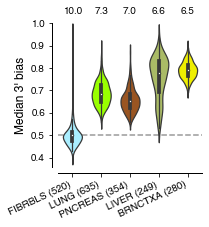

In [8]:
sample_ids = sample_df[sample_df['tissue_id'].isin(
    ['Liver', 'Pancreas', 'Lung', 'Cells_Cultured_fibroblasts', 'Brain_Cortex']
)].index

# sort tissues by average RIN
median_s = sample_df.loc[sample_ids].groupby('tissue_id').apply(
    lambda x: x['SMRIN'].median()).sort_values(ascending=False)
order = median_s.index
abbrv_dict = gtex_metrics_df[['tissue_id', 'tissue_abbrv']].drop_duplicates().set_index('tissue_id')['tissue_abbrv'].to_dict()
order = order.map(abbrv_dict)
num_s = sample_df.loc[sample_ids].groupby('tissue_id').apply(len).rename(index=abbrv_dict)

colors = {
    'LIVER': '#AABB66',
    'PNCREAS': '#995522',
    'LUNG': '#99FF00',
    'FIBRBLS': '#AAEEFF',
    'BRNCTXA': '#EEEE00',
}    

ax = qtl.plot.setup_figure(2,2, xspace=[0.75, 0.25])
ax.margins(0.02)
sns.violinplot(x='tissue_abbrv', y="Median 3' bias",
               data=gtex_metrics_df.loc[sample_ids], ax=ax, 
               palette=colors, order=order, 
               scale='width', width=0.66, linewidth=1.25, saturation=1)
ax.set_xlabel(None)
ax.plot([-0.5,4.5], [0.5,0.5], '--', c=[0.6]*3, zorder=-10)

# median RIN
for k,i in enumerate(median_s.values):
    ax.text(k, 1.04, i, ha='center', fontsize=10)

qtl.plot.format_plot(ax, fontsize=10, x_offset=6, y_offset=6)
ax.set_ylim([ax.get_ylim()[0], 1])
ax.set_ylabel("Median 3' bias", fontsize=12)
ax.set_xlim([-0.5, 4.5])
ax.set_xticklabels(order, rotation=30, ha='right');
ax.set_xticklabels(order +' ('+num_s[order].astype(str)+')',
                   rotation=25, ha='right')
plt.savefig('pdf/bias_distributions.pdf')

#### Panel D: correlation of 3' bias with PCs

PC2: R2 = 0.64


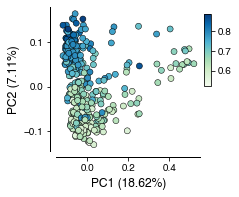

In [9]:
tissue_id = 'Colon_Sigmoid'
sample_ids = sample_df[sample_df['tissue_id'] == tissue_id].index

# compute PCs
pc_df, pve_s = qtl.pca.get_pcs(gtex_counts_df[sample_ids])

ax, cax = qtl.plot.setup_figure(2, 2, xspace=[0.75, 0.5],
                                colorbar=True, ds=0.05, cw=0.1, ct=0.1)
h = ax.scatter(pc_df['PC1'], pc_df['PC2'],
               c=gtex_metrics_df.loc[sample_ids, "Median 3' bias"], 
               cmap=plt.cm.GnBu,
               clip_on=False, s=36, edgecolor='k',lw=0.5,
              )
ax.set_xlabel(f"PC1 ({pve_s['PC1']:.2f}%)", fontsize=12)
ax.set_ylabel(f"PC2 ({pve_s['PC2']:.2f}%)", fontsize=12)
ax.set_yticks([-0.1, 0.0, 0.1])
qtl.plot.format_plot(ax, fontsize=10)
ax.spines['left'].set_position(('outward', 6))
ax.spines['bottom'].set_position(('outward', 6))
hc = plt.colorbar(h, cax=cax)
hc.set_ticks([0.6,0.7,0.8])
plt.savefig(f'pdf/{tissue_id}.PCA_bias.pdf')

r = stats.pearsonr(pc_df['PC2'], gtex_metrics_df.loc[sample_ids, "Median 3' bias"])[0]
print(f'PC2: R2 = {r**2:.2f}')

#### Panel E: FFPE data

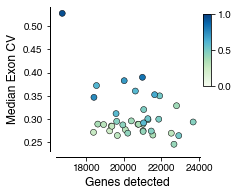

In [10]:
ax, cax = rnaseqc.plot.detection_bias(ffpe_metrics_df, bias_metric="Median Exon CV", ct=0.1)
cax.set_ylabel('')
plt.savefig('pdf/FFPE.genes_vs_CV.scatter.pdf')